In [171]:
# Note: this uses matplotlib 2.0 and librosa 0.5dev
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg
import matplotlib.style as ms
ms.use('seaborn-muted')
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

In [262]:
y, sr = librosa.load('../../tests/mandolin_trem.mp3', sr=None, offset=0.75, duration=0.5)
#y, sr = librosa.load('../../tests/sax_cres.mp3', sr=None, offset=0.75, duration=0.5)

In [278]:
fmin = librosa.note_to_hz('C3')
OVERSAMPLE = 3
N_OCT = 7

C = librosa.cqt(y=y, sr=sr, bins_per_octave=OVERSAMPLE*12, n_bins=N_OCT*OVERSAMPLE*12,
                hop_length=128, fmin=fmin)

freqs = librosa.cqt_frequencies(C.shape[0], fmin, bins_per_octave=OVERSAMPLE*12)
fmax = freqs.max()

In [287]:
Cl = librosa.logamplitude(C**2, ref_power=np.max, amin=1e-8, top_db=60)

In [292]:
ms.use('seaborn-paper')

<IPython.core.display.Javascript object>


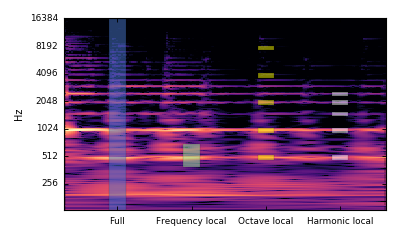

In [296]:
plt.figure(figsize=(5, 3))


# Draw the spectrogram
ax = librosa.display.specshow(Cl, y_axis='cqt_hz', sr=sr,
                              bins_per_octave=OVERSAMPLE*12, fmin=librosa.note_to_hz('C3'))


# Draw the full-height filter
ax.add_patch(patches.Rectangle((24, fmin), 9, fmax - fmin, alpha=0.5, label='Full height'))

# Draw a local filter
ax.add_patch(patches.Rectangle((64, librosa.note_to_hz('G4')),
                               9, 
                               librosa.note_to_hz('F5') - librosa.note_to_hz('G4'),
                               facecolor='lightgreen',
                               alpha=0.5, label='Frequency-local'))


# Draw octave-local filters
base_f = librosa.note_to_hz('Cb5')


filters = []
for harm in [1, 2, 4, 8, 16]:
    bottom = librosa.midi_to_hz(librosa.hz_to_midi(base_f * harm) - 1) # go down 3 semitones
    top = librosa.midi_to_hz(librosa.hz_to_midi(base_f * harm) + 1)
    filters.append(patches.Rectangle((104, bottom), 9, top - bottom))


pc = PatchCollection(filters, facecolor='yellow', alpha=0.5, label='Octave-local')
pc.set_label('Octave-local')
ax.add_collection(pc)



# Draw harmonics
filters = []
for harm in [1, 2, 3, 4, 5]:
    bottom = librosa.midi_to_hz(librosa.hz_to_midi(base_f * harm) - 1) # go down 3 semitones
    top = librosa.midi_to_hz(librosa.hz_to_midi(base_f * harm) + 1)
    filters.append(patches.Rectangle((144, bottom), 9, top - bottom))

    
pc = PatchCollection(filters, facecolor='white', alpha=0.5, label='Harmonic-local')
pc.set_label('Harmonic-local')
ax.add_collection(pc)

plt.xticks([24+4.5, 64+4.5, 104+4.5, 144+4.5],
          ['Full', 'Frequency local', 'Octave local', 'Harmonic local'])
plt.tight_layout()

plt.savefig('filter-shapes.png', transparent=False, pad_inches=0)

In [266]:
from IPython.display import Audio

In [281]:
Audio(data=y, rate=sr)